___

<a href='http://www.pieriandata.com'><img src='../Pierian_Data_Logo.png'/></a>
___
<center><em>Авторские права принадлежат Pierian Data Inc.</em></center>
<center><em>Для дополнительной информации посетите наш сайт <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>

# Деревья решений - Decision Trees

## Данные

Мы будем использовать один и тот же набор данных для всех методов классификации на основе деревьев (Деревья решений - Decision Tree, Случайные леса - Random Forests и Расширяемые деревья - Gradient Boosted Trees). Это позволит нам сравнивать работу этих методов между собой.

Мы будем работать с набором данных "Palmer Penguins" - он достаточно простой для того, чтобы мы могли понять влияние гиперпараметров на результаты классификации.

<img src="penguin.jpg" style="max-width:400px">

Данные были собраны и предоставлены Кристиной Горман и антарктической станцией Палмер, расположенной на острове Анверс, к северу от Южного полярного круга.  

Более подробно см. следующую работу на английском языке: Gorman KB, Williams TD, Fraser WR (2014) Ecological Sexual Dimorphism and Environmental Variability within a Community of Antarctic Penguins (Genus Pygoscelis). PLoS ONE 9(3): e90081. doi:10.1371/journal.pone.0090081


* penguins_size.csv: Упрощённые данные из исходного набора данных о пингвинах. Содержит следующие переменные:

    * species: разновидности пингвинов - Антарктический пингвин (Chinstrap), Пингвин Адели (Adélie) или Папуанский пингвин (Gentoo)
    * culmen_length_mm: длина клюва (mm)
    * culmen_depth_mm: высота клюва (mm)
    * flipper_length_mm: длина крыла (mm)
    * body_mass_g: масса тела (g)
    * island: название острова (Dream, Torgersen или Biscoe) на архипелаге Палмер (Антарктика)
    * sex: пол пингвина

**Наша цель - создать модель, которая поможет нам определять вид пингвина на основе его физических атрибутов, чтобы исследователи могли с помощью этой модели классифицировать пингвинов, без необходимости привлечения опытного биолога.**

## Imports

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [114]:
df = pd.read_csv("../DATA/penguins_size.csv")

In [115]:
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


## Исследование данных - EDA

### Отсутствующие значения - Missing Data

Если какие-то значения отсутствуют и их немного, то мы можем удалить такие данные. Однако для использования нашей будущей модели мы предполагаем, что для новых пингвинов все признаки будут измеряться без пропусков.

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [117]:
df.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [118]:
# Какой процент данных мы удаляем?
100*(10/344)

2.9069767441860463

In [119]:
df = df.dropna()

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    object 
 1   island             334 non-null    object 
 2   culmen_length_mm   334 non-null    float64
 3   culmen_depth_mm    334 non-null    float64
 4   flipper_length_mm  334 non-null    float64
 5   body_mass_g        334 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.9+ KB


In [121]:
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


In [122]:
df['sex'].unique()

array(['MALE', 'FEMALE', '.'], dtype=object)

In [123]:
df['island'].unique()

array(['Torgersen', 'Biscoe', 'Dream'], dtype=object)

In [124]:
df = df[df['sex']!='.']

## Визуализация

<AxesSubplot:xlabel='culmen_length_mm', ylabel='culmen_depth_mm'>

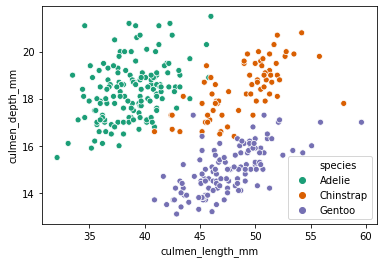

In [125]:
sns.scatterplot(x='culmen_length_mm',y='culmen_depth_mm',data=df,hue='species',palette='Dark2')

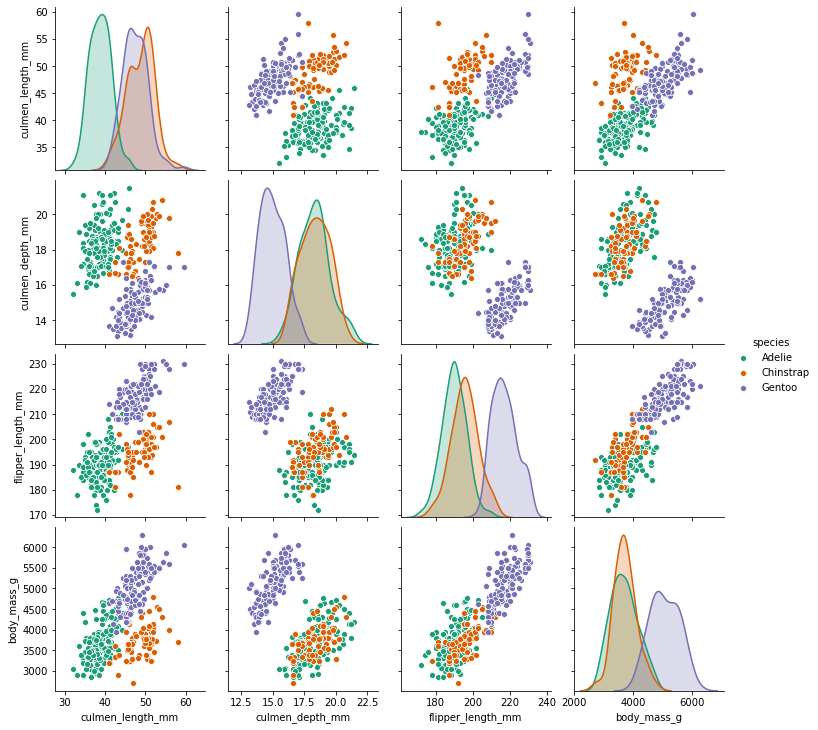

In [126]:
sns.pairplot(df,hue='species',palette='Dark2')

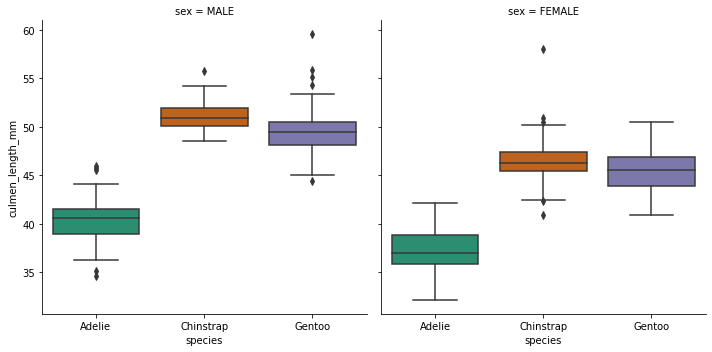

In [127]:
sns.catplot(x='species',y='culmen_length_mm',data=df,kind='box',col='sex',palette='Dark2')

## Построение признаков - Feature Engineering

In [128]:
pd.get_dummies(df)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,species_Adelie,species_Chinstrap,species_Gentoo,island_Biscoe,island_Dream,island_Torgersen,sex_FEMALE,sex_MALE
0,39.1,18.7,181.0,3750.0,1,0,0,0,0,1,0,1
1,39.5,17.4,186.0,3800.0,1,0,0,0,0,1,1,0
2,40.3,18.0,195.0,3250.0,1,0,0,0,0,1,1,0
4,36.7,19.3,193.0,3450.0,1,0,0,0,0,1,1,0
5,39.3,20.6,190.0,3650.0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,0,0,1,1,0,0,1,0
340,46.8,14.3,215.0,4850.0,0,0,1,1,0,0,1,0
341,50.4,15.7,222.0,5750.0,0,0,1,1,0,0,0,1
342,45.2,14.8,212.0,5200.0,0,0,1,1,0,0,1,0


In [130]:
pd.get_dummies(df.drop('species',axis=1),drop_first=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_MALE
0,39.1,18.7,181.0,3750.0,0,1,1
1,39.5,17.4,186.0,3800.0,0,1,0
2,40.3,18.0,195.0,3250.0,0,1,0
4,36.7,19.3,193.0,3450.0,0,1,0
5,39.3,20.6,190.0,3650.0,0,1,1
...,...,...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,0,0,0
340,46.8,14.3,215.0,4850.0,0,0,0
341,50.4,15.7,222.0,5750.0,0,0,1
342,45.2,14.8,212.0,5200.0,0,0,0


## Разбиение на обучающий и тестовый наборы данных - Train | Test Split

In [131]:
X = pd.get_dummies(df.drop('species',axis=1),drop_first=True)
y = df['species']

In [132]:
from sklearn.model_selection import train_test_split

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Классификатор "Дерево решений" - Decision Tree Classifier

## Гиперпараметры по умолчанию

In [137]:
from sklearn.tree import DecisionTreeClassifier

In [138]:
model = DecisionTreeClassifier()

In [140]:
model.fit(X_train,y_train)

DecisionTreeClassifier()

In [141]:
base_pred = model.predict(X_test)

## Оценка работы модели

In [157]:
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix

In [158]:
confusion_matrix(y_test,base_pred)

array([[38,  2,  0],
       [ 1, 26,  0],
       [ 1,  0, 32]], dtype=int64)

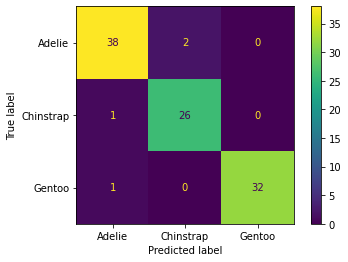

In [161]:
plot_confusion_matrix(model,X_test,y_test)

In [144]:
print(classification_report(y_test,base_pred))

              precision    recall  f1-score   support

      Adelie       0.95      0.95      0.95        40
   Chinstrap       0.93      0.96      0.95        27
      Gentoo       1.00      0.97      0.98        33

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



In [174]:
model.feature_importances_

array([0.33350103, 0.02010577, 0.57575804, 0.        , 0.04491847,
       0.        , 0.02571668])

In [177]:
pd.DataFrame(index=X.columns,data=model.feature_importances_,columns=['Feature Importance'])

,Feature Importance
culmen_length_mm,0.333501
culmen_depth_mm,0.020106
flipper_length_mm,0.575758
body_mass_g,0.000000
island_Dream,0.044918
island_Torgersen,0.000000
sex_MALE,0.025717


<AxesSubplot:xlabel='species', ylabel='body_mass_g'>

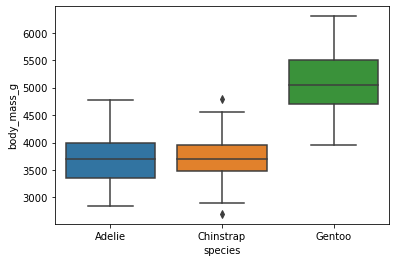

In [180]:
sns.boxplot(x='species',y='body_mass_g',data=df)

## Визуализация дерева

Эта функция относительно новая, при желании Вы можете посмотреть онлайн-документацию:

https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html

In [145]:
from sklearn.tree import plot_tree

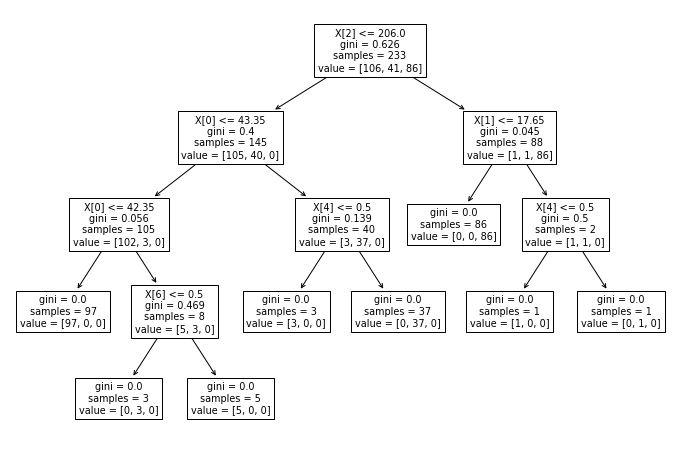

In [153]:
plt.figure(figsize=(12,8))
plot_tree(model);

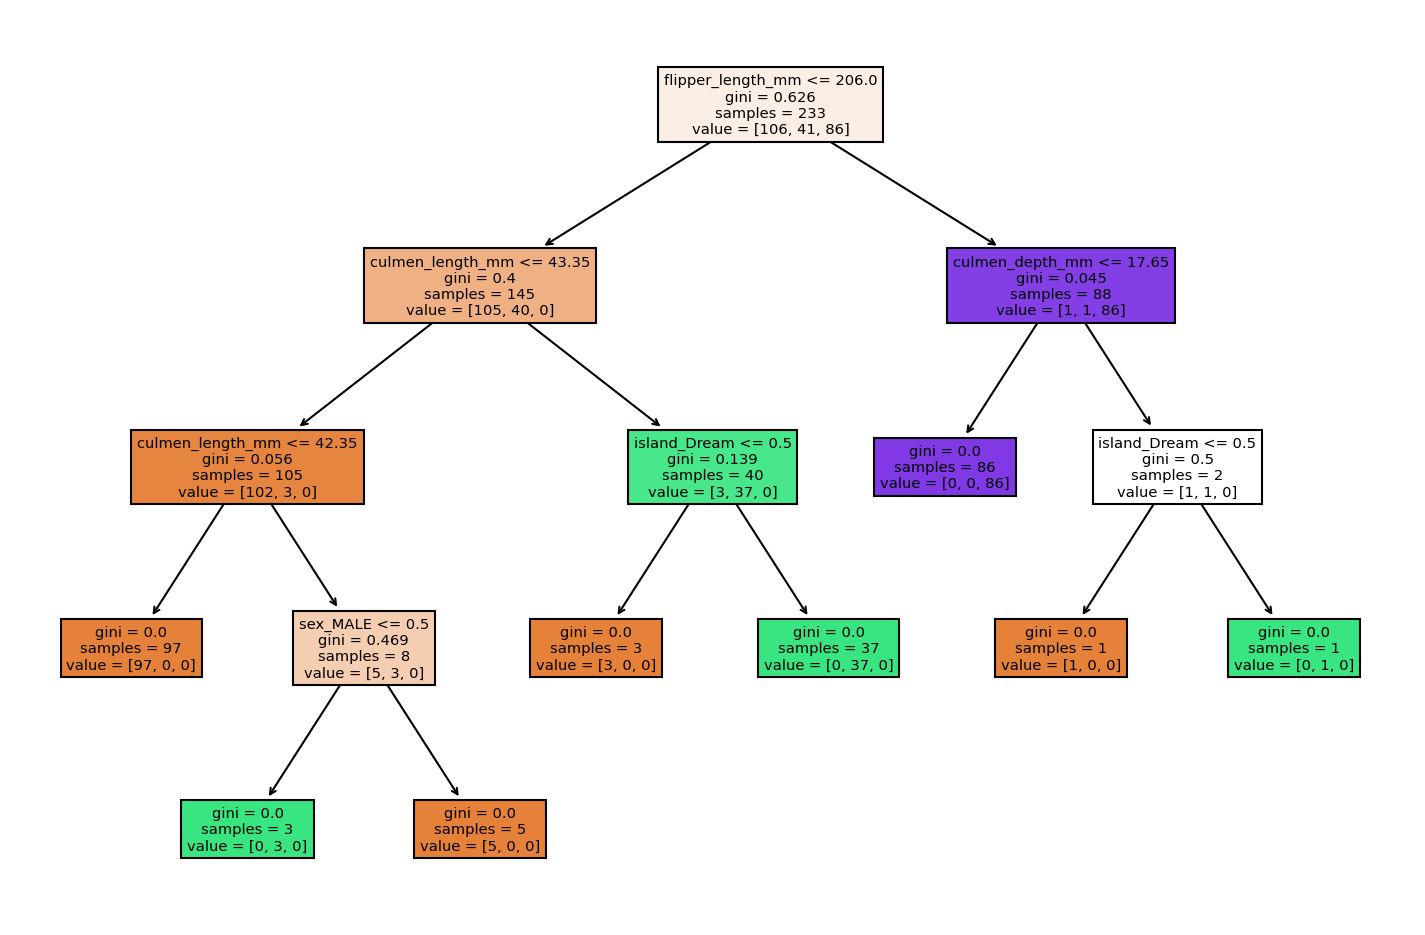

In [166]:
plt.figure(figsize=(12,8),dpi=150)
plot_tree(model,filled=True,feature_names=X.columns);

## Результаты модели

Чтобы поэкспериментировать с гиперпараметрами, давайте создадим функцию, которая возвращает результаты классификации, а также рисует дерево.

In [171]:
def report_model(model):
    model_preds = model.predict(X_test)
    print(classification_report(y_test,model_preds))
    print('\n')
    plt.figure(figsize=(12,8),dpi=150)
    plot_tree(model,filled=True,feature_names=X.columns);

## Гиперпараметры

### Гиперпараметр "Max Depth"

In [168]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort='deprecated', ccp_alpha=0.0)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choos

In [169]:
pruned_tree = DecisionTreeClassifier(max_depth=2)
pruned_tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2)

              precision    recall  f1-score   support

      Adelie       0.87      0.97      0.92        40
   Chinstrap       0.91      0.78      0.84        27
      Gentoo       1.00      0.97      0.98        33

    accuracy                           0.92       100
   macro avg       0.93      0.91      0.91       100
weighted avg       0.92      0.92      0.92       100





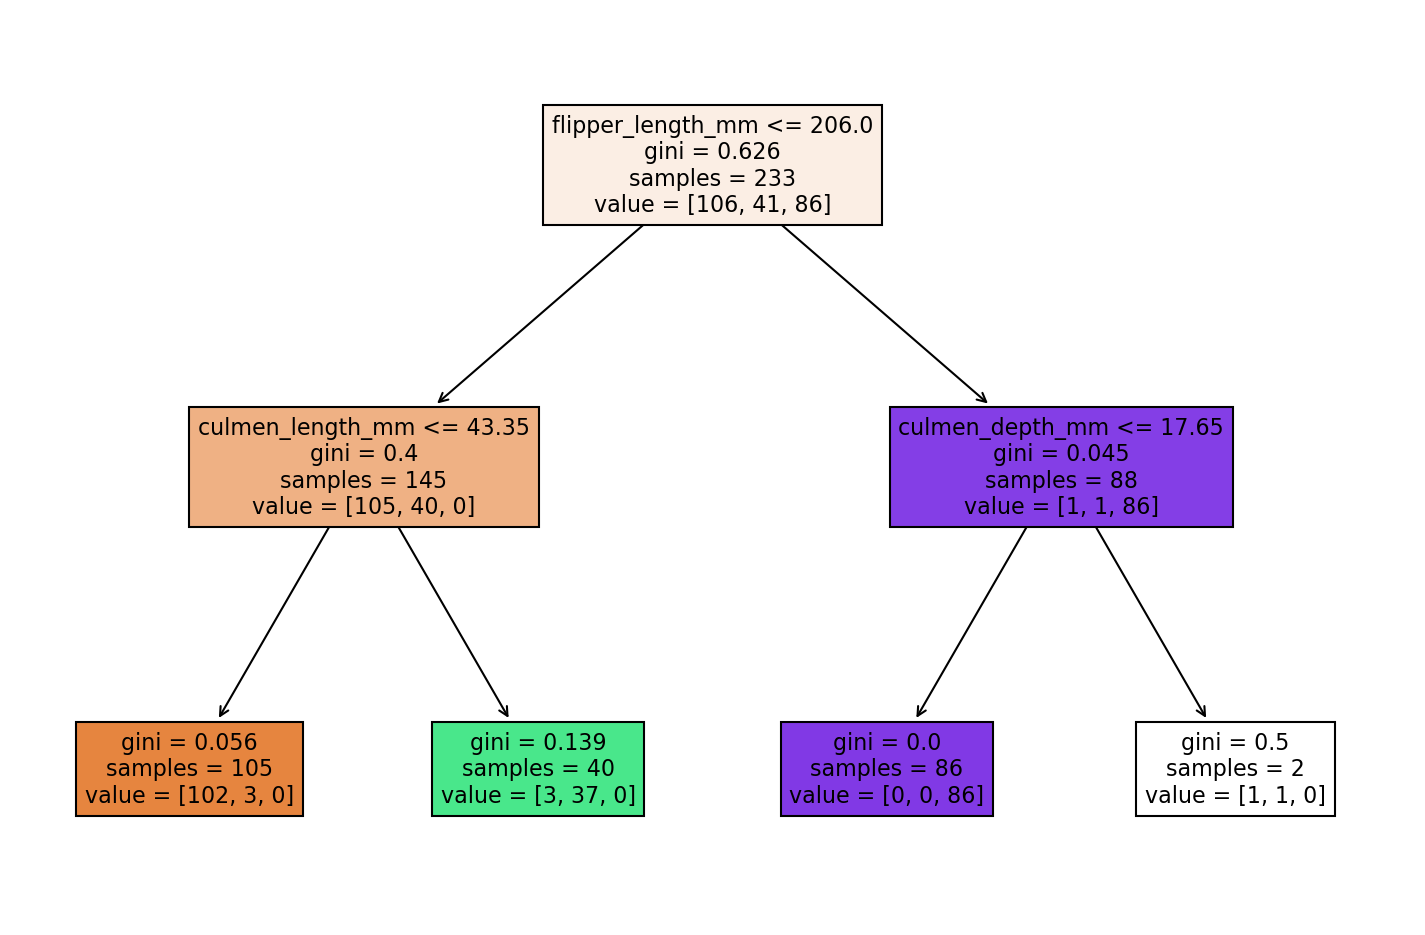

In [172]:
report_model(pruned_tree)

## Гиперпараметр "Max Leaf Nodes"

In [185]:
pruned_tree = DecisionTreeClassifier(max_leaf_nodes=3)
pruned_tree.fit(X_train,y_train)

DecisionTreeClassifier(max_leaf_nodes=3)

              precision    recall  f1-score   support

      Adelie       0.95      0.95      0.95        40
   Chinstrap       0.91      0.78      0.84        27
      Gentoo       0.86      0.97      0.91        33

    accuracy                           0.91       100
   macro avg       0.91      0.90      0.90       100
weighted avg       0.91      0.91      0.91       100





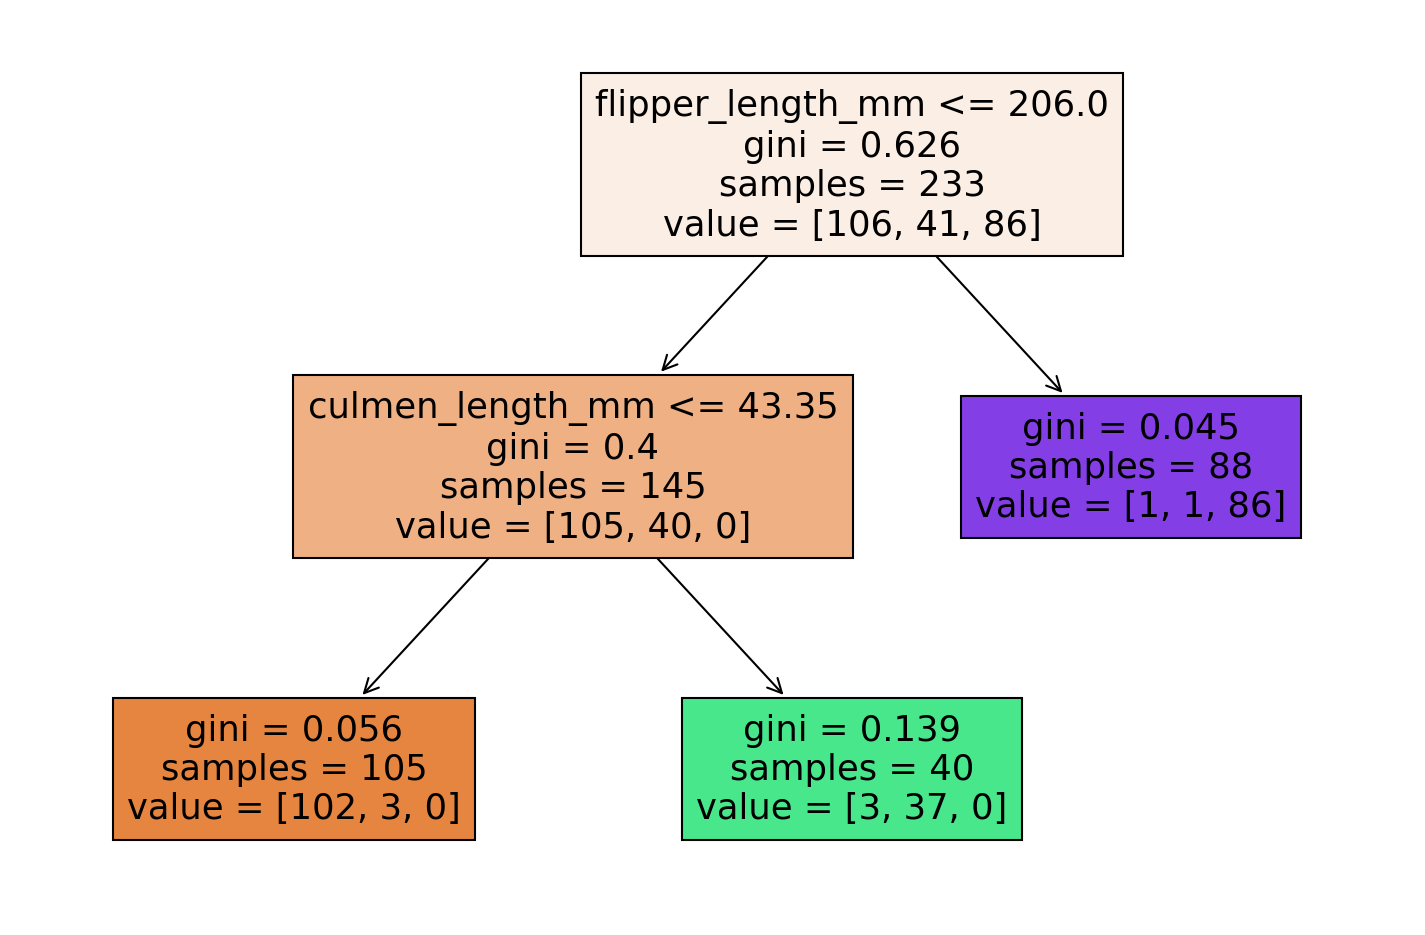

In [186]:
report_model(pruned_tree)

## Гиперпараметр "Criterion"

In [187]:
entropy_tree = DecisionTreeClassifier(criterion='entropy')
entropy_tree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy')

              precision    recall  f1-score   support

      Adelie       0.95      0.95      0.95        40
   Chinstrap       0.93      0.96      0.95        27
      Gentoo       1.00      0.97      0.98        33

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100





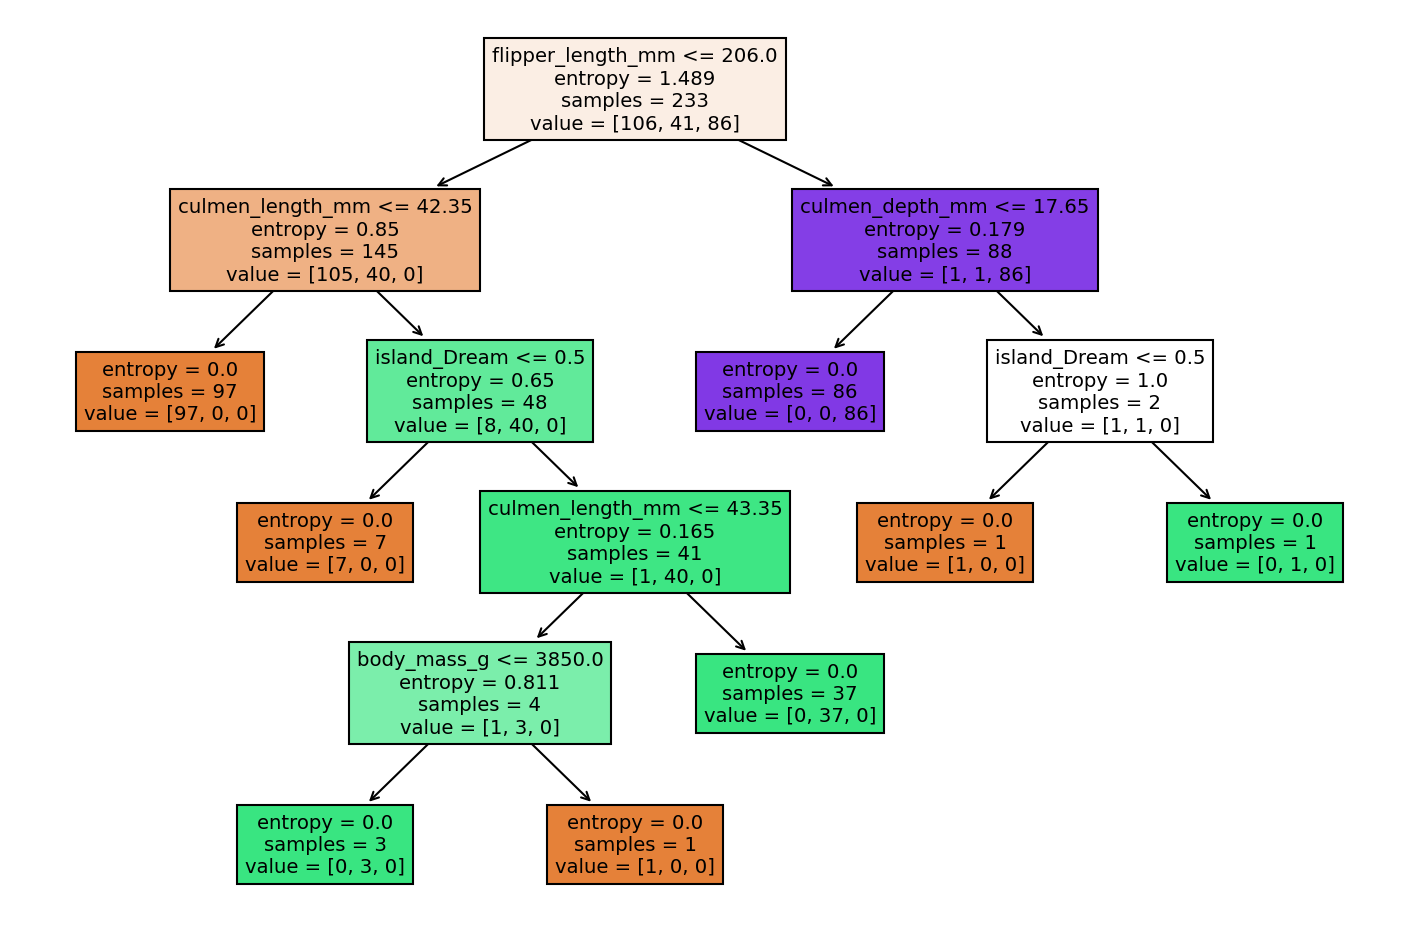

In [188]:
report_model(entropy_tree)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../DATA/penguins_size.csv')

In [3]:
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [4]:
df['species'].unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [5]:
df.isnull()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,True,True,True,True,True
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
339,False,False,True,True,True,True,True
340,False,False,False,False,False,False,False
341,False,False,False,False,False,False,False
342,False,False,False,False,False,False,False


In [6]:
df.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [11]:
df = df.dropna(
    
)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    object 
 1   island             334 non-null    object 
 2   culmen_length_mm   334 non-null    float64
 3   culmen_depth_mm    334 non-null    float64
 4   flipper_length_mm  334 non-null    float64
 5   body_mass_g        334 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.9+ KB


In [13]:
df.corr(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.228640,0.652126,0.589066
culmen_depth_mm,-0.228640,1.000000,-0.578730,-0.472987
flipper_length_mm,0.652126,-0.578730,1.000000,0.873211
body_mass_g,0.589066,-0.472987,0.873211,1.000000


In [14]:
df['island'].unique()

array(['Torgersen', 'Biscoe', 'Dream'], dtype=object)

In [15]:
df['sex'].unique()

array(['MALE', 'FEMALE', '.'], dtype=object)

In [16]:
df[df['sex'] == '.']

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,.


In [22]:
df[df['species'] == 'Gentoo'].groupby('sex').describe().T

sex                           .       FEMALE         MALE
culmen_length_mm  count     1.0    58.000000    61.000000
                  mean     44.5    45.563793    49.473770
                  std       NaN     2.051247     2.720594
                  min      44.5    40.900000    44.400000
                  25%      44.5    43.850000    48.100000
                  50%      44.5    45.500000    49.500000
                  75%      44.5    46.875000    50.500000
                  max      44.5    50.500000    59.600000
culmen_depth_mm   count     1.0    58.000000    61.000000
                  mean     15.7    14.237931    15.718033
                  std       NaN     0.540249     0.741060
                  min      15.7    13.100000    14.100000
                  25%      15.7    13.800000    15.200000
                  50%      15.7    14.250000    15.700000
                  75%      15.7    14.600000    16.100000
                  max      15.7    15.500000    17.300000
flipper_length_mm count     1.0    58.000000    61.000000
                  mean    217.0   212.706897   221.540984
                  std       NaN     3.897856     5.673252
                  min     217.0   203.000000   208.000000
                  25%     217.0   210.000000   218.000000
                  50%     217.0   212.000000   221.000000
                  75%     217.0   215.000000   225.000000
                  max     217.0   222.000000   231.000000
body_mass_g       count     1.0    58.000000    61.000000
                  mean   4875.0  4679.741379  5484.836066
                  std       NaN   281.578294   313.158596
                  min    4875.0  3950.000000  4750.000000
                  25%    4875.0  4462.500000  5300.000000
                  50%    4875.0  4700.000000  5500.000000
                  75%    4875.0  4875.000000  5700.000000
                  max    4875.0  5200.000000  6300.000000

In [24]:
df.at[336, 'sex'] = 'FEMALE'

In [52]:
df.loc[335, 'sex'] = 'FEMALE'

In [53]:
df.loc[335]

species              Gentoo
island                  NaN
culmen_length_mm       55.1
culmen_depth_mm        16.0
flipper_length_mm     230.0
body_mass_g          5850.0
sex                  FEMALE
Name: 335, dtype: object

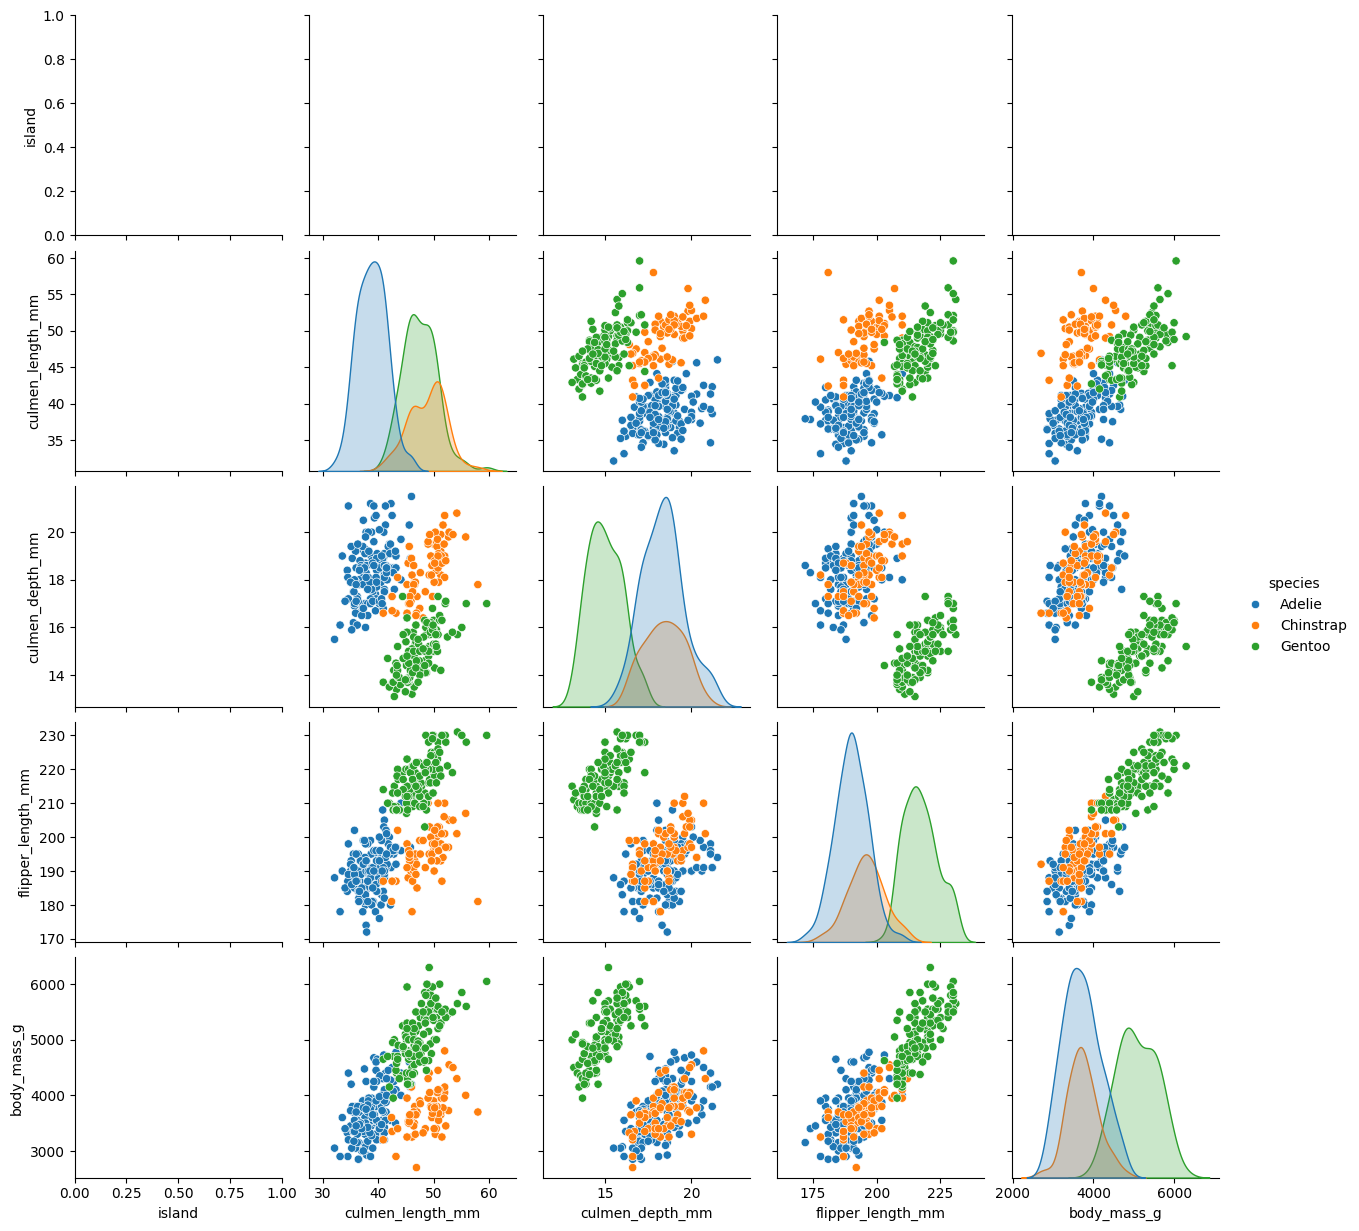

In [65]:
sns.pairplot(df, hue='species')

In [64]:
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,NaN,39.1,18.7,181.0,3750.0,MALE
1,Adelie,NaN,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,NaN,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,NaN,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,NaN,39.3,20.6,190.0,3650.0,MALE


In [66]:
df1 = df.copy()

In [67]:
df1.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,NaN,39.1,18.7,181.0,3750.0,MALE
1,Adelie,NaN,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,NaN,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,NaN,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,NaN,39.3,20.6,190.0,3650.0,MALE


In [68]:
df1['island'] = df1['island'].map({'Torgersen': np.mean(df['culmen_depth_mm'])})

In [69]:
df1

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,NaN,39.1,18.7,181.0,3750.0,MALE
1,Adelie,NaN,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,NaN,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,NaN,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,NaN,39.3,20.6,190.0,3650.0,MALE
...,...,...,...,...,...,...,...
338,Gentoo,NaN,47.2,13.7,214.0,4925.0,FEMALE
340,Gentoo,NaN,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,NaN,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,NaN,45.2,14.8,212.0,5200.0,FEMALE


In [70]:
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,NaN,39.1,18.7,181.0,3750.0,MALE
1,Adelie,NaN,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,NaN,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,NaN,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,NaN,39.3,20.6,190.0,3650.0,MALE


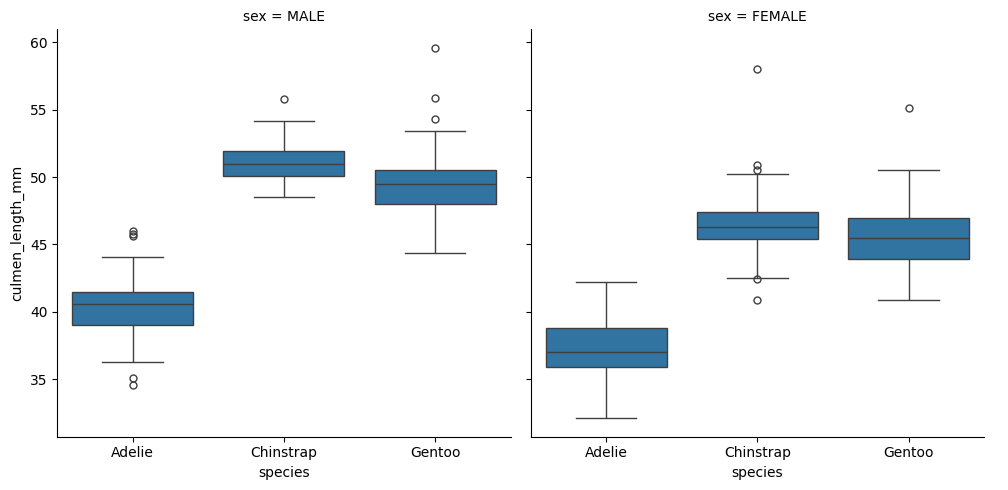

In [71]:
sns.catplot(x='species', y='culmen_length_mm', data=df, kind='box', col='sex')

In [72]:
df['island']

0     NaN
1     NaN
2     NaN
4     NaN
5     NaN
       ..
338   NaN
340   NaN
341   NaN
342   NaN
343   NaN
Name: island, Length: 334, dtype: float64

In [73]:
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,NaN,39.1,18.7,181.0,3750.0,MALE
1,Adelie,NaN,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,NaN,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,NaN,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,NaN,39.3,20.6,190.0,3650.0,MALE


In [101]:
df = pd.read_csv('../DATA/penguins_size.csv')

In [102]:
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [103]:
df.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [104]:
df = df.dropna()

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    object 
 1   island             334 non-null    object 
 2   culmen_length_mm   334 non-null    float64
 3   culmen_depth_mm    334 non-null    float64
 4   flipper_length_mm  334 non-null    float64
 5   body_mass_g        334 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.9+ KB


In [106]:
df.at[336, 'sex'] = 'FEMALE'

In [107]:
df.loc[336]

species              Gentoo
island               Biscoe
culmen_length_mm       44.5
culmen_depth_mm        15.7
flipper_length_mm     217.0
body_mass_g          4875.0
sex                  FEMALE
Name: 336, dtype: object

In [108]:
df['island']

0      Torgersen
1      Torgersen
2      Torgersen
4      Torgersen
5      Torgersen
         ...    
338       Biscoe
340       Biscoe
341       Biscoe
342       Biscoe
343       Biscoe
Name: island, Length: 334, dtype: object

In [110]:
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


In [117]:
X = pd.get_dummies(df.drop('species', axis=1), drop_first=True)

In [118]:
y = df['species']

In [115]:
from sklearn.model_selection import train_test_split


In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [120]:
from sklearn.tree import DecisionTreeClassifier

In [121]:
model = DecisionTreeClassifier()

In [122]:
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [123]:
base_preds = model.predict(X_test)

In [125]:
#y_test

In [129]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [127]:
print(classification_report(y_test, base_preds))

              precision    recall  f1-score   support

      Adelie       0.93      0.98      0.95        41
   Chinstrap       0.95      0.87      0.91        23
      Gentoo       1.00      1.00      1.00        37

    accuracy                           0.96       101
   macro avg       0.96      0.95      0.95       101
weighted avg       0.96      0.96      0.96       101



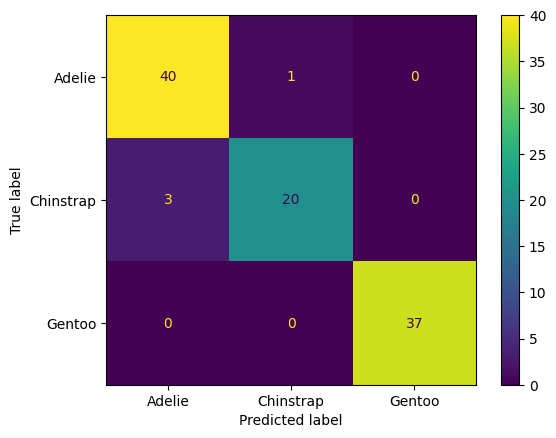

In [128]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

In [130]:
confusion_matrix(y_test, base_preds)

array([[40,  1,  0],
       [ 3, 20,  0],
       [ 0,  0, 37]], dtype=int64)

In [132]:
model.feature_importances_

array([0.33514864, 0.04203954, 0.542054  , 0.00239775, 0.0681854 ,
       0.01017467, 0.        ])

In [133]:
X.columns

Index(['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'island_Dream', 'island_Torgersen', 'sex_MALE'],
      dtype='object')

In [136]:
pd.DataFrame(index=X.columns, data=model.feature_importances_, columns=['Важность признаков']).sort_values('Важность признаков')

,Важность признаков
sex_MALE,0.000000
body_mass_g,0.002398
island_Torgersen,0.010175
culmen_depth_mm,0.042040
island_Dream,0.068185
culmen_length_mm,0.335149
flipper_length_mm,0.542054


In [137]:
from sklearn.tree import plot_tree

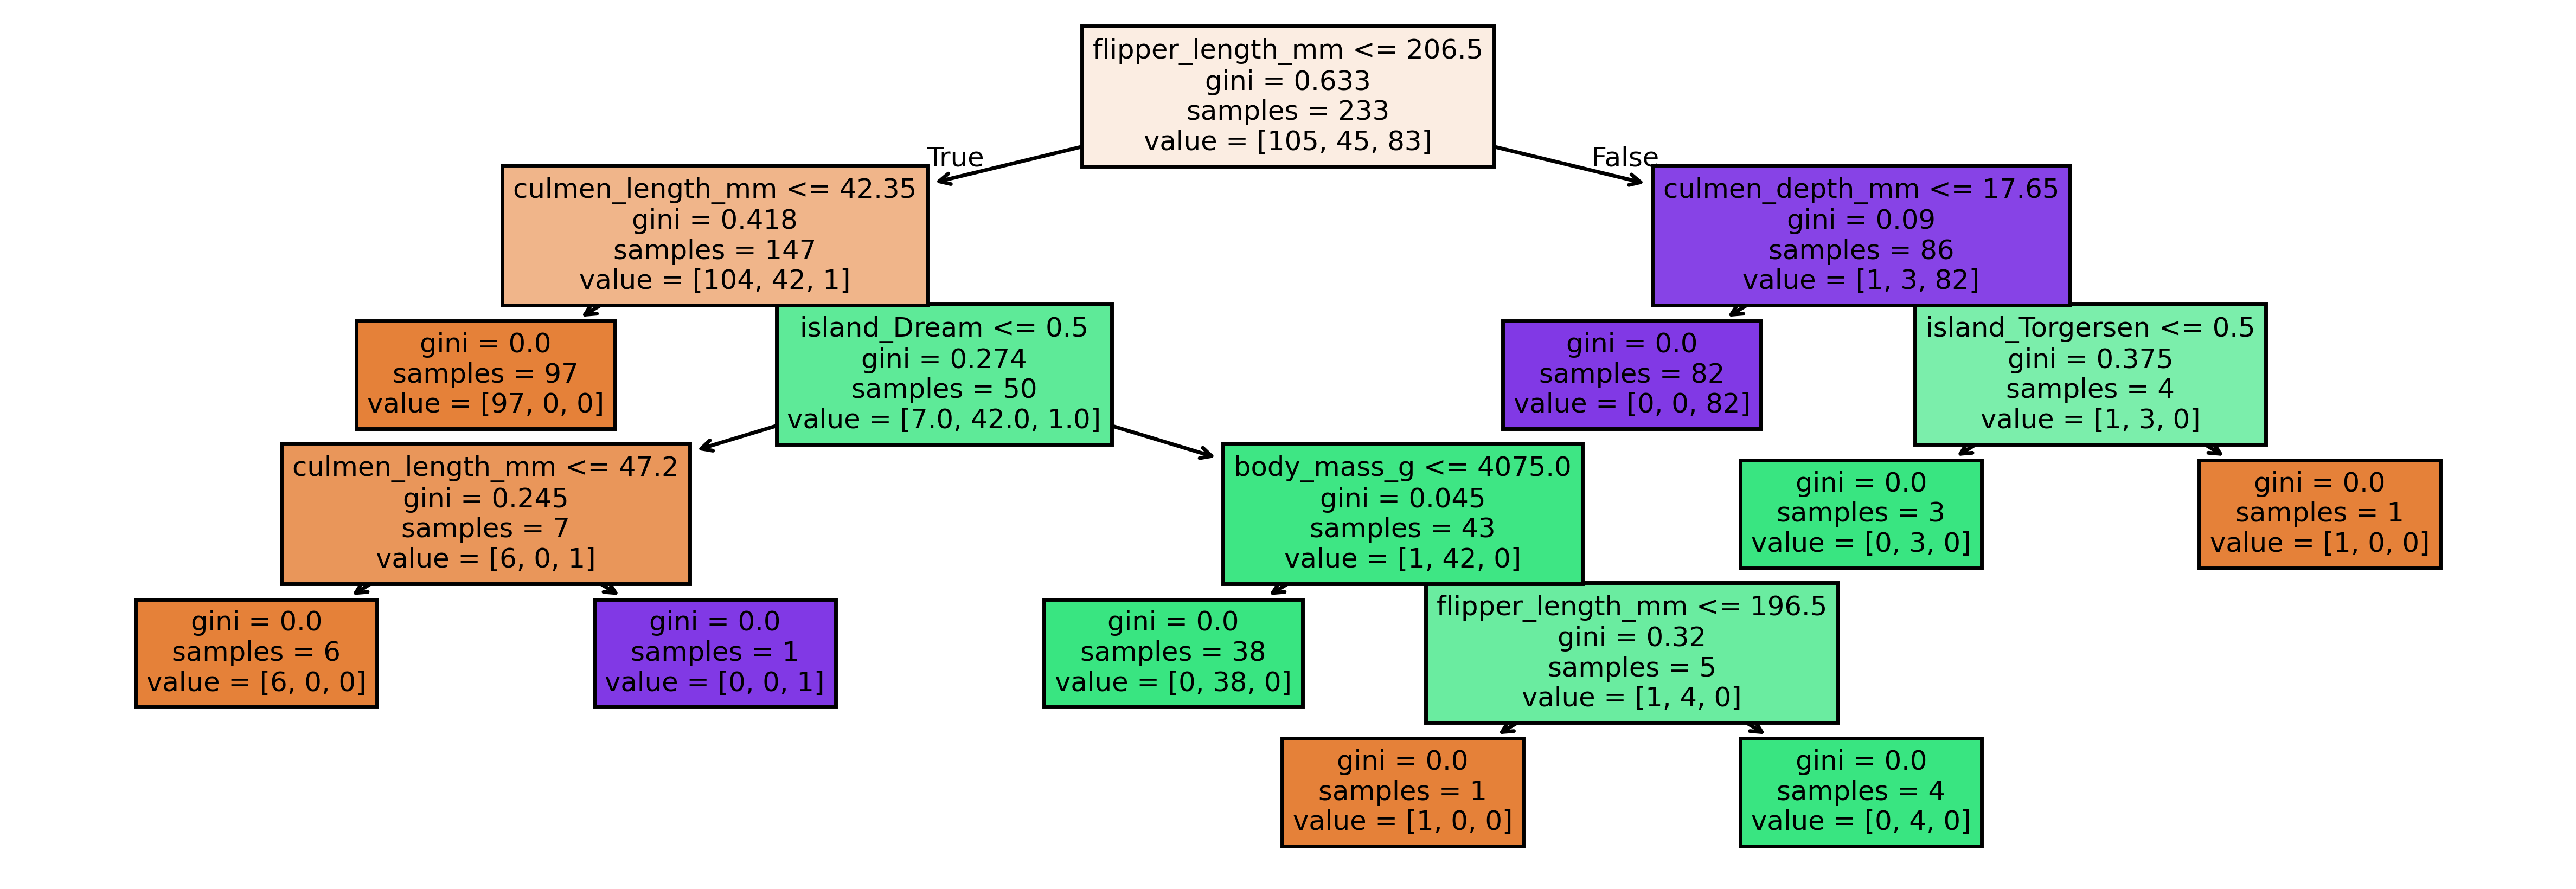

In [148]:
plt.figure(figsize=(12,4), dpi=500)
plot_tree(model, feature_names=X.columns, filled=True);

In [149]:
def report_model(model):
    model_preds = model.predict(X_test)
    print(classification_report(y_test, model_preds))
    print('\n')
    plt.figure(figsize=(12, 8), dpi=200)
    plot_tree(model, feature_names=X.columns, filled=True)

              precision    recall  f1-score   support

      Adelie       0.93      0.98      0.95        41
   Chinstrap       0.95      0.87      0.91        23
      Gentoo       1.00      1.00      1.00        37

    accuracy                           0.96       101
   macro avg       0.96      0.95      0.95       101
weighted avg       0.96      0.96      0.96       101





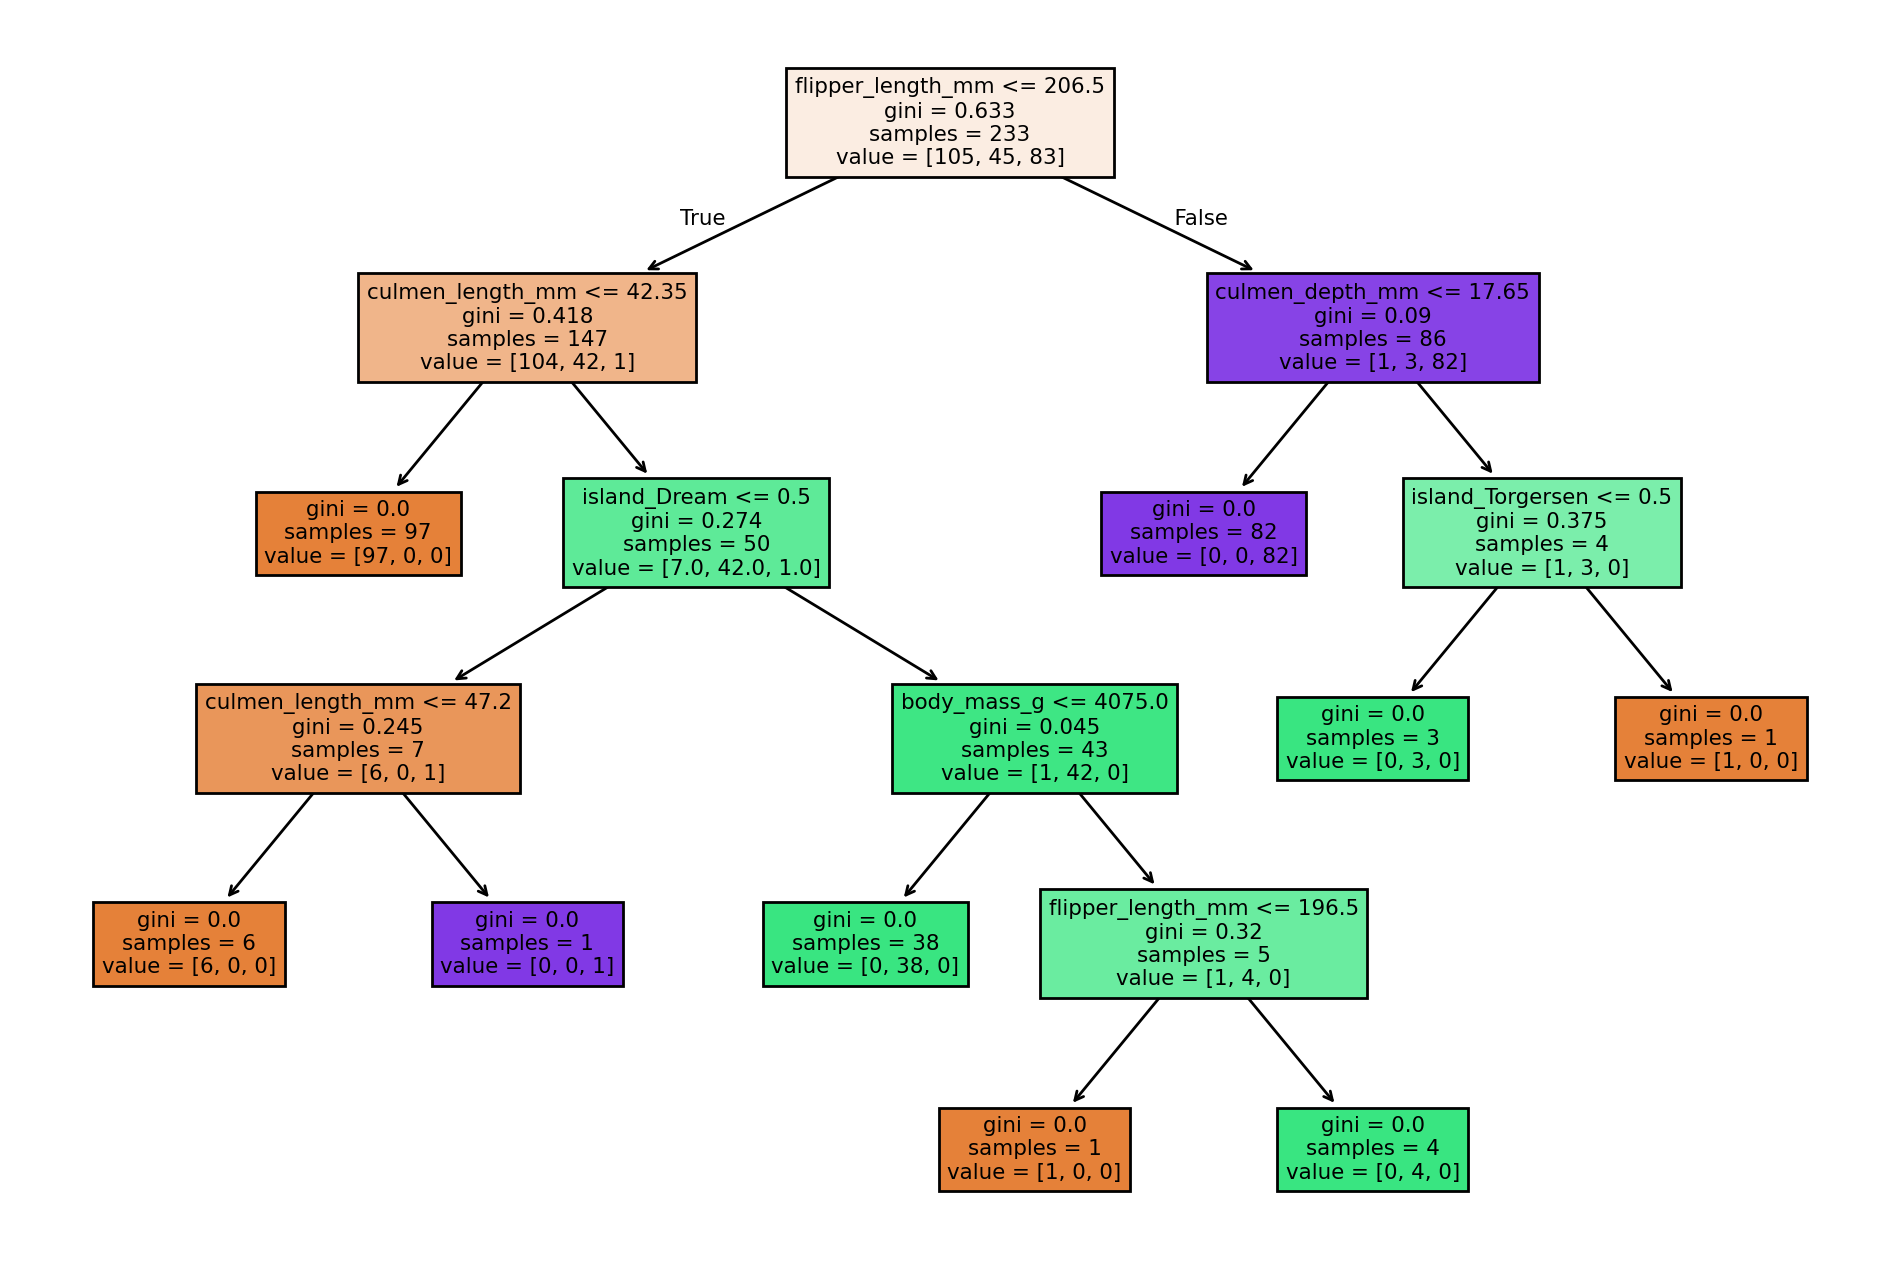

In [150]:
report_model(model)

In [166]:
pruned_tree = DecisionTreeClassifier(max_depth=3)

In [167]:
pruned_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

              precision    recall  f1-score   support

      Adelie       0.97      0.95      0.96        41
   Chinstrap       0.92      0.96      0.94        23
      Gentoo       1.00      1.00      1.00        37

    accuracy                           0.97       101
   macro avg       0.96      0.97      0.97       101
weighted avg       0.97      0.97      0.97       101





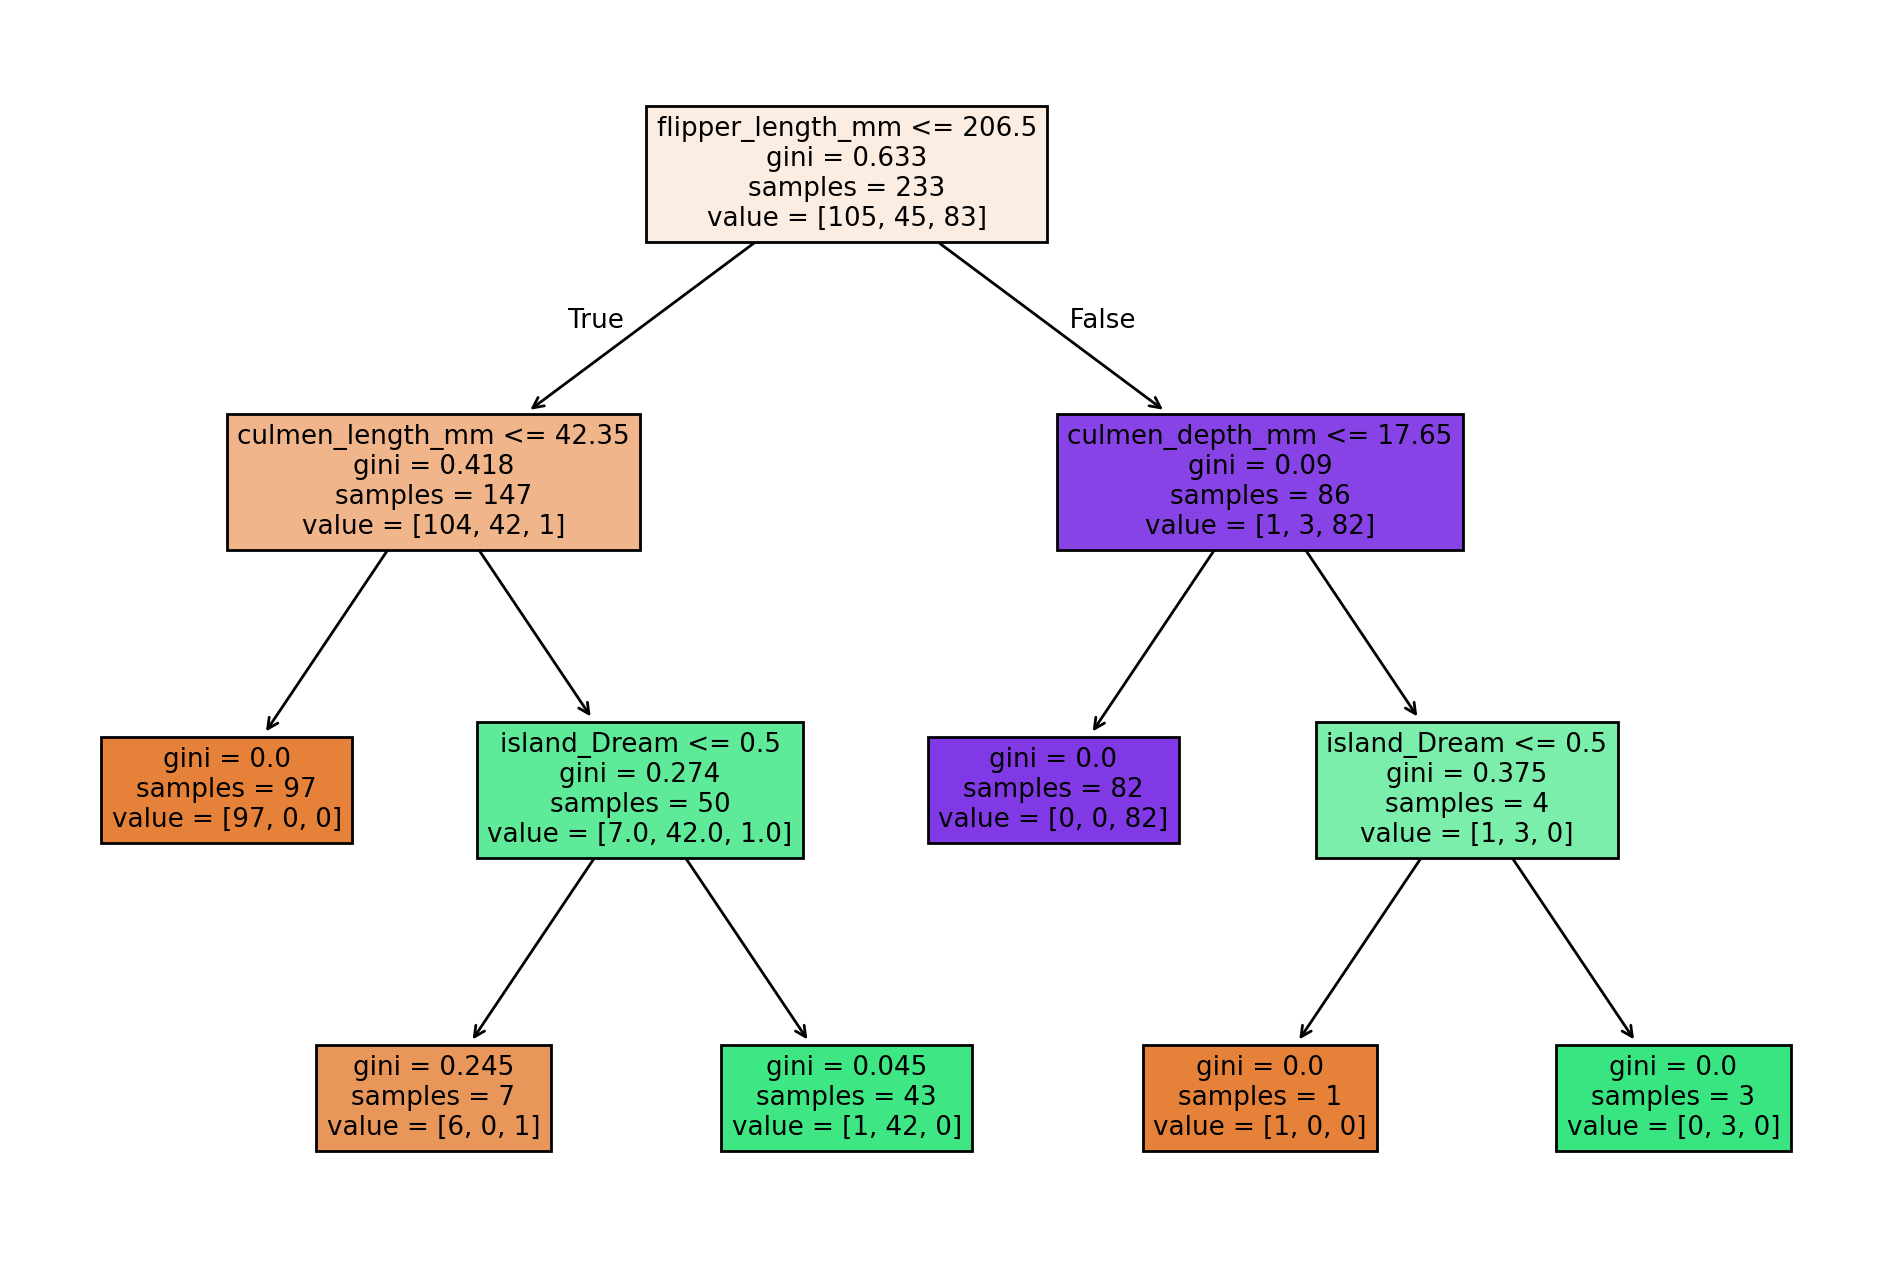

In [168]:
report_model(pruned_tree)

In [186]:
max_leaf_tree = DecisionTreeClassifier(max_leaf_nodes=3)

In [187]:
max_leaf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=3)

              precision    recall  f1-score   support

      Adelie       0.97      0.88      0.92        41
   Chinstrap       0.83      0.87      0.85        23
      Gentoo       0.93      1.00      0.96        37

    accuracy                           0.92       101
   macro avg       0.91      0.92      0.91       101
weighted avg       0.92      0.92      0.92       101





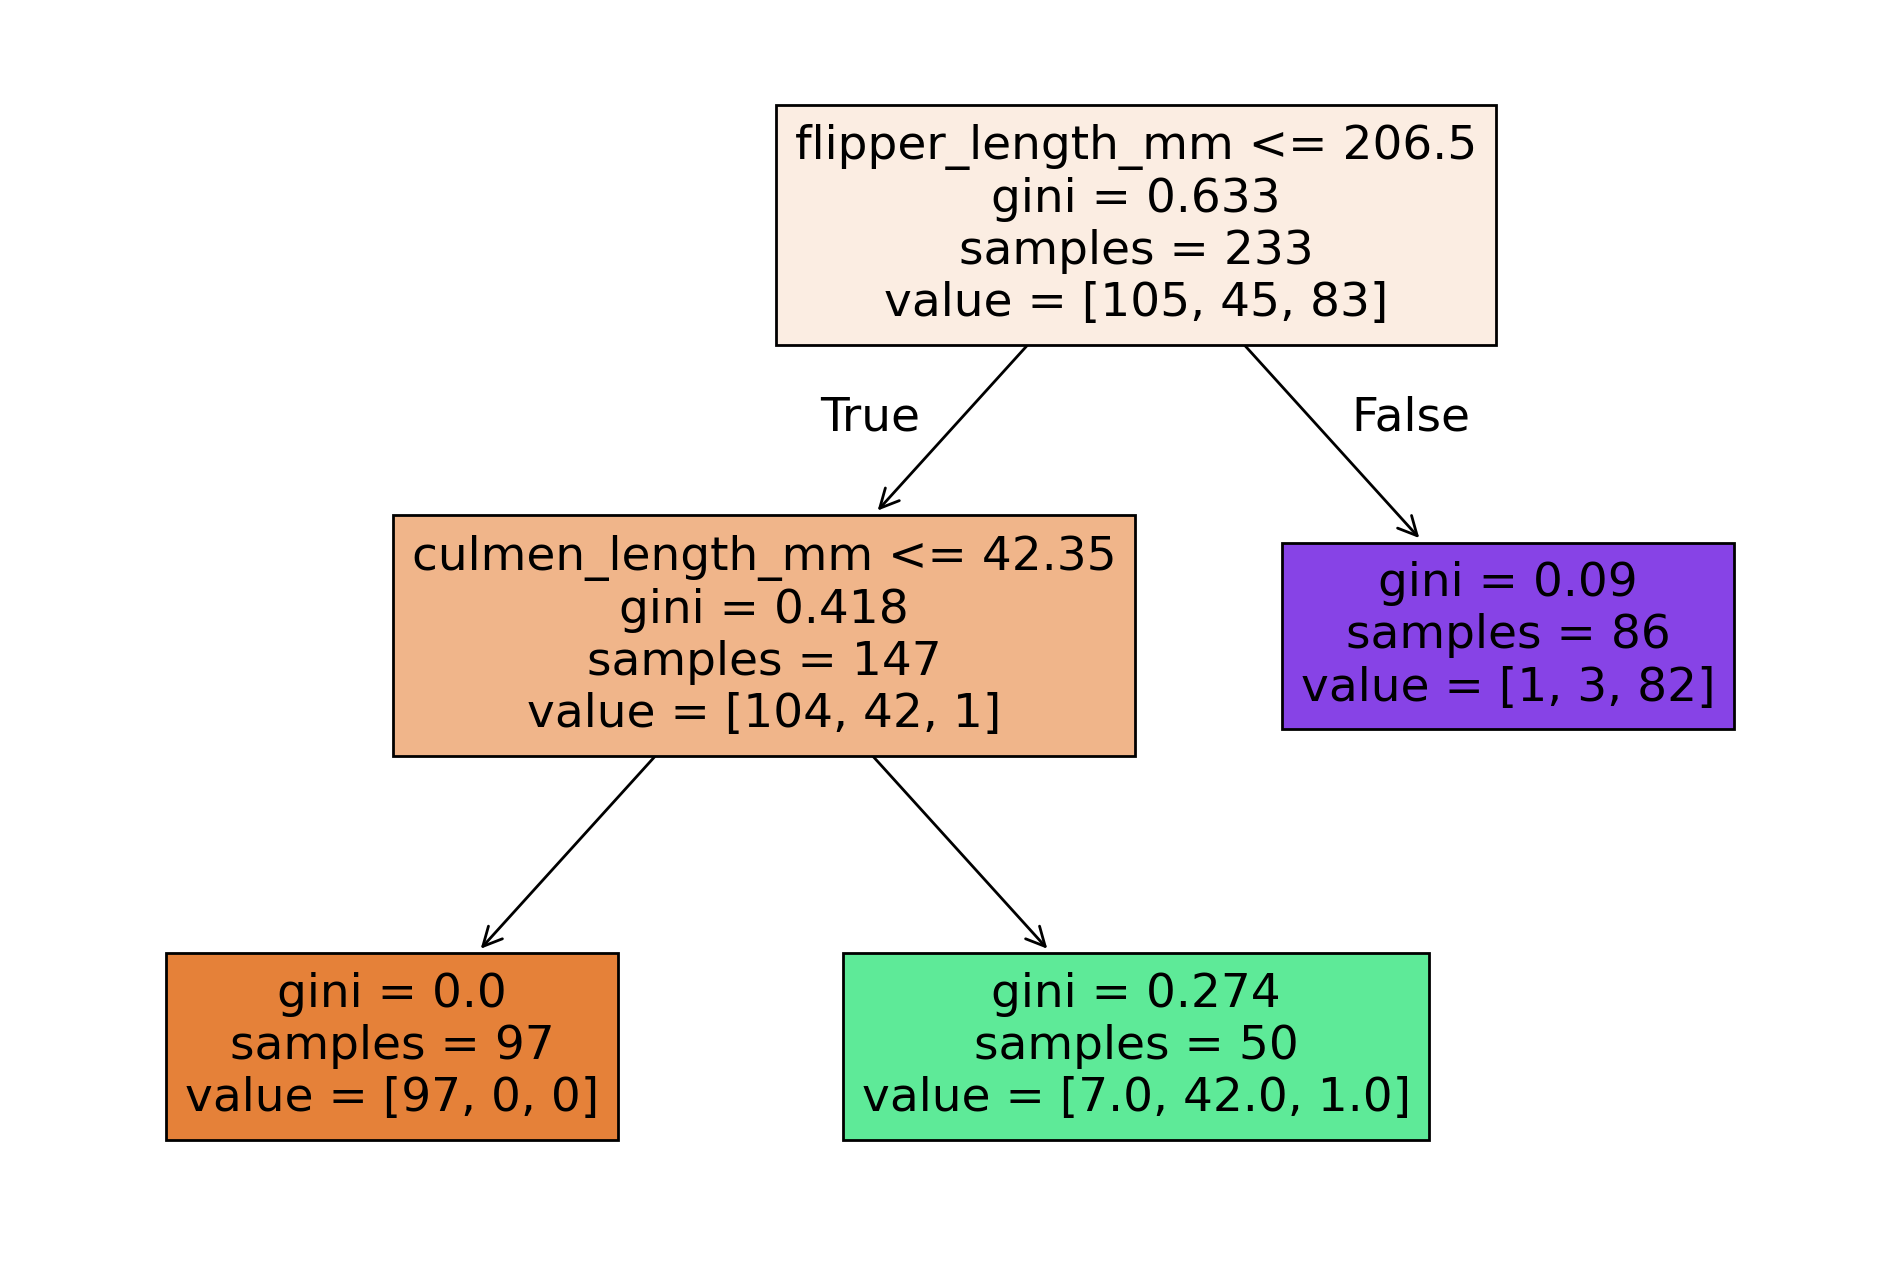

In [188]:
report_model(max_leaf_tree)

In [190]:
entropy_tree = DecisionTreeClassifier(criterion='entropy')

In [191]:
print('ggg')

ggg


In [192]:
'ggg'

'ggg'

In [193]:
entropy_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

              precision    recall  f1-score   support

      Adelie       0.91      0.98      0.94        41
   Chinstrap       0.95      0.83      0.88        23
      Gentoo       1.00      1.00      1.00        37

    accuracy                           0.95       101
   macro avg       0.95      0.93      0.94       101
weighted avg       0.95      0.95      0.95       101





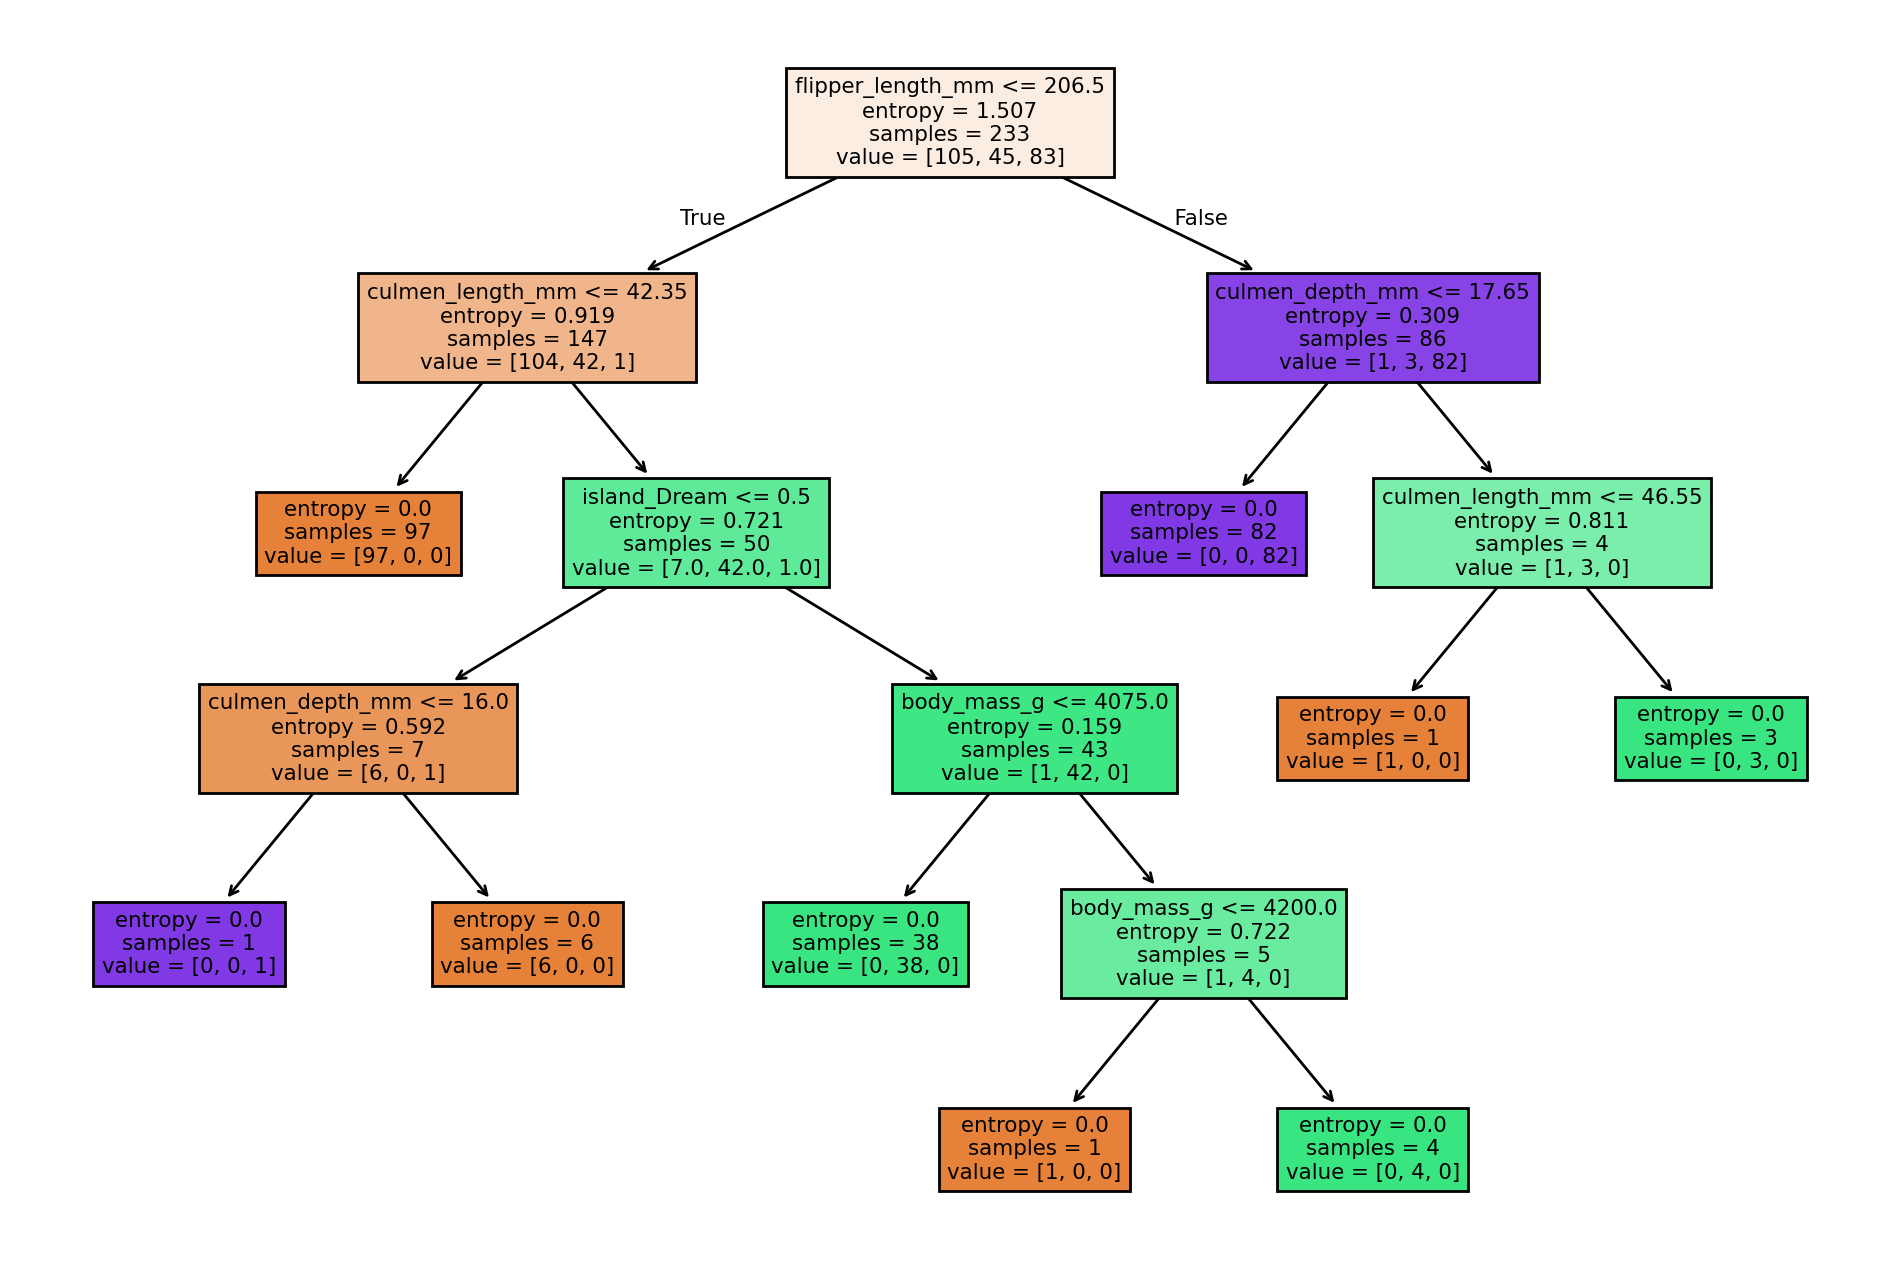

In [194]:
report_model(entropy_tree)

In [195]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0, monotonic_cst=None)
 |
 |  A decision tree classifier.
 |
 |  Read more in the :ref:`User Guide <tree>`.
 |
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy", "log_loss"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "log_loss" and "entropy" both for the
 |      Shannon information gain, see :ref:`tree_mathematical_formulation`.
 |
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies ar